# NetCDF Tutorial
#### By: Anthony Harding
### This is a tutorial on how to work with netCDF files in R and how to extract information from them using overlaying shapefiles.
Network Common Data Form (NetCDF) is a file type for multidimensional data (denoted with ".nc" file extension). It is commonly used for data in the climate and atmospheric sciences fields. Commonly, netCDF data will have 3 dimensions: latitude, longitude, and time. A primary benefit of netCDF file format over other multidimensional file formats is the ability to store metadata in the file along with the data.<br>
In this file I will:<br>
&emsp;1) Show how to import a netCDF file in R<br>
&emsp;2) Provide information about netCDF files<br>
&emsp;3) How to plot spatial data in netCDF<br>
&emsp;4) Show how to import a shapefile in R<br>
&emsp;5) Show how to extract information from a netCDF file by overlaying shapefiles.

#### Import packages used and set working directory

In [8]:
library("ncdf4") # Used to read netcdf files
library("sp")
library("rgdal") # Used to read shapefiles
#library("raster") # Used to convert to raster (currently commented out b/c causes notebook crashes)
"%&%"<-function(x,y)paste(x,y,sep="")

In [9]:
setwd("C:/Users/Tony/OneDrive - Harvard University/Dropbox/Tutorials/NetCDF") # Adjust to appropriate working directory path

### 1) How to import a netCDF file
To work with netCDF files in R I use the ncdf4 package. The function ncdf4::nc_open() will read in a netCDF file.<br>
Here I read in a netCDF file with global gridded monthly surface air temperatures from UDel (https://psl.noaa.gov/data/gridded/data.UDel_AirT_Precip.html)

In [10]:
nc <- nc_open("data/input/air.mon.mean.v501.nc")

### 2) Information about netCDF files
A primary benefit of the netCDF format is that it contains metadata describing the data contained in the file. Below are a few examples.

In [11]:
print("Filename: "%&%nc$filename) # Print the filename
print("Variables: "%&%names(nc$var)) # Print variables
print("# Dims = "%&%nc$ndims) # Print the number of dimensions
print(names(nc$dim)) # Print dimension names
print("Lat units: "%&%nc$dim$lat$units%&%"; Lon units: "%&%nc$dim$lon$units%&%"; Time units: "%&%nc$dim$time$units) # Print dimension units

[1] "Filename: data/input/air.mon.mean.v501.nc"
[1] "Variables: air"
[1] "# Dims = 3"
[1] "lat"  "lon"  "time"
[1] "Lat units: degrees_north; Lon units: degrees_east; Time units: hours since 1900-1-1 0:0:0"


### 3) How to plot spatial netCDF data
Often netCDF data contains spatial data as latitude and longitude coordinates. Here I will show how to plot this information by converting to a raster.<br>
Rasters are akin to a matrix but allow for a coordinate system. This makes them instrumental in spatial data analysis. <br>
Here I use the raster() function to create a raster for the spatial temperature data in June 2010. nc[c(361:720,1:360),1:360,1326] gets the spatial data (first and second elements) for the month of January 2010 (third element). aperm(.,c(2,1)) transposes the data. xmn,xmx,ymn,ymx define the extents of the spatial data. <br>
Once the information is converted to a raster, it can be plotted with the plot() function. The rasterToPoints() function can be used to convert raster data into a dataframe with x,y coordinates.

In [4]:
rt_6_2010 <- raster(aperm(nc[c(361:720,1:360),1:360,1326],c(2,1)),xmn=-180,xmx=180,ymn=-90,ymx=90) # Convert spatial data for one month to a raster
plot(rt_6_2010)
dfrt_6_2010 <- data.frame(rasterToPoints(rt_6_2010))
colnames(dfrt_6_2010) <- c("x","y","Temperature")

ERROR: Error in raster(aperm(nc[c(361:720, 1:360), 1:360, 1326], c(2, 1)), xmn = -180, : could not find function "raster"


### 4) How to import shapefile in R
Often spatial data in the form of latitude and longitude as given by netCDF files will need to be aggregated so that it can be assigned to a larger spatial object, such as a city, region, or country. This can be done by extracting information using shapefiles. <br>
Shapefiles (denoted with ".shp" file extension) is a vector data format for spatial data. These can describe a variety of objects, such as points, lines, or polygons. As with netCDFs, shapefiles often contain metadata describing the objects contained in the data. <br>
There are multiple ways to read shapefiles in R. Here, I use the rgdal::readOGR() function to read in a shapefile containing information about countries, represented by polygons.

In [5]:
ctybrd <- readOGR('Data/Input/shape/country.shp') # read in shapefile of countries

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\Tony\OneDrive - Harvard University\Dropbox\Tutorials\NetCDF\data\input\shape\country.shp", layer: "country"
with 251 features
It has 13 fields
Integer64 fields read as strings:  POP_CNTRY 


#### We can plot one variable from the data to get an idea of what it looks like.
Spatial data can be plotted using the spplot() function.

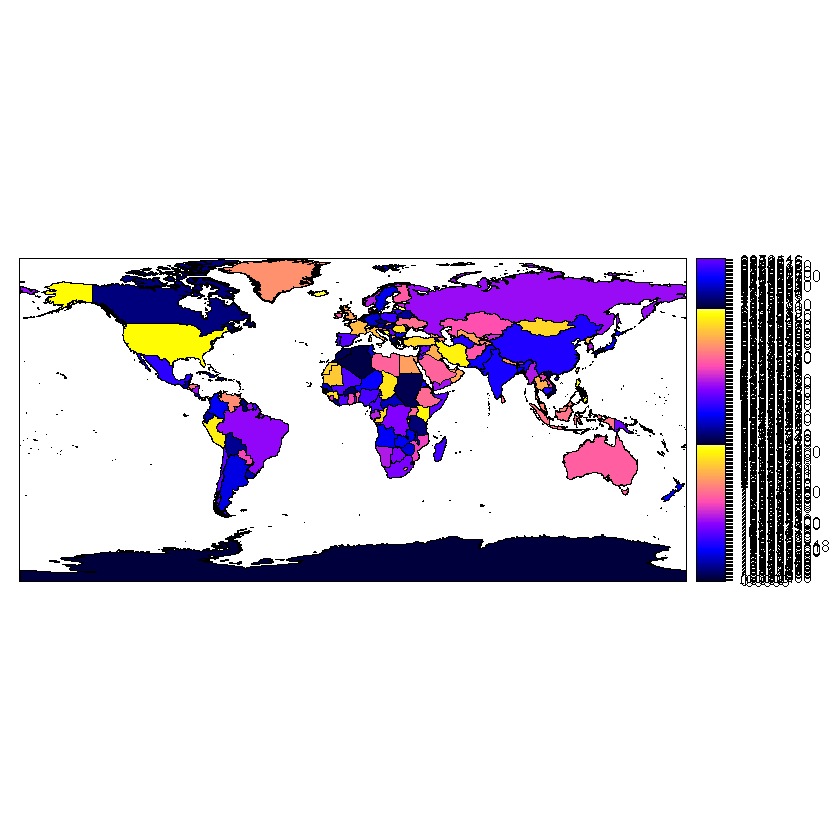

In [6]:
spplot(ctybrd,"POP_CNTRY") # Plot population of countries

### 5) How to aggregate spatial data from netCDF using shapefiles
Often spatial data in the form of latitude and longitude as given by netCDF files will need to be aggregated so that it can be assigned to a larger spatial object, such as a city, region, or country. This can be done by extracting information using shapefiles. <br>
Here, I provide an example by extracting temperature data for June 2010 and assigning the gridded temperature data to countries. <br>
The raster::extract() function can be used to extract data from a raster using shapefile objects. Returned is a list of cell values for contained by the borders of each shapefile object.

In [ ]:
extt_6_2010 <- extract(rt_6_2010,ctybrd,small=T,progress="text") # Extract rasterized temperatures and assign to countries

We now aggregate the cells for each spatial object (in this case countries) however preferred (eg. sum, average, median). These aggregated values are then converted into a dataframe to be exported or used in an analysis.

In [ ]:
t_6_2010_sum <- mapply(sum,tmpext,na.rm=T) # Sum cell values within border
t_6_2010_mean <- mapply(mean,tmpext,na.rm=T) # Average cell values within border
t_6_2010_median <- mapply(median,tmpext,na.rm=T) # Median cell values within border

In [ ]:
dftemp <- data.frame(ctybrd@data[,1:3],t_6_2010_mean)  # Convert country average temperature into dataframe
colnames(dftemp) <- c(colnames(ctybrd[1:3]),"Temperature")

We can also append the temperature data to the shapefile to plot it.

In [ ]:
ctybrd@data <- merge(ctybrd@data,dftemp[,c("GMI_CNTRY","Temperature")],by="GMI_CNTRY")
spplot(ctybrd,"Temperature")